## Perceptron

               
Como hemos discutido, el perceptrón te permite resolver **problemas de clasificación binaria**, es decir, clasificar ejemplos de entrada en dos clases: podemos llamarlas **positiva** y **negativa**.
               
Primero, vamos a importar algunas bibliotecas necesarias.

In [ ]:
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

: 

## Problema de Juguete

Para comenzar, vamos a empezar con un problema de juguete, donde tenemos dos características de entrada. Por ejemplo, en medicina podríamos querer clasificar tumores en benignos y malignos, dependiendo de su tamaño y edad.

Generaremos un conjunto de datos de clasificación aleatorio usando la función `make_classification` de la biblioteca SciKit Learn:

Vamos a graficar también el conjunto de datos:
               

In [6]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # convert initial 0/1 values into -1/1
X = X.astype(np.float32); Y = Y.astype(np.int32) # features - float, label - int

# Split the dataset into training and test
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-0.12386572  0.08091224]
 [ 1.0110611  -1.1546923 ]
 [ 0.5600562   0.593963  ]
 [-0.6032916   0.50357723]]
Labels:
 [ 1 -1  1  1]


Grafiquemos el dataset:

/var/folders/wd/0sm_658d23ldnfyfjn6y4s6m0000gn/T/ipykernel_2317/2456380072.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


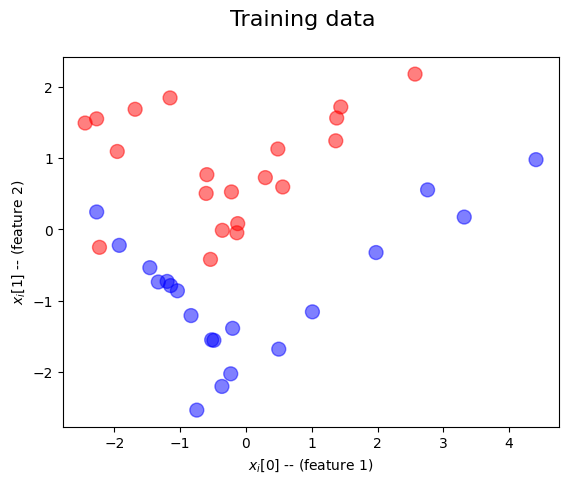

In [7]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Training data', train_x, train_labels)

## Perceptrón

Como el perceptrón es un clasificador binario, para cada vector de entrada $x$ la salida de nuestro perceptrón será +1 o -1, dependiendo de la clase. La salida se calcula usando la fórmula

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

donde $\mathbf{w}$ es el vector de pesos, $f$ es una función de activación escalón:
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

Sin embargo, un modelo lineal genérico también debería tener un sesgo (bias), es decir, idealmente deberíamos calcular $y$ como $y=f(\mathbf{w}^{\mathrm{T}}\mathbf{x}+\mathbf{b})$. Para simplificar nuestro modelo, podemos eliminar este término de sesgo añadiendo una dimensión extra a nuestras características de entrada, que siempre vale 1:


In [10]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples.shape, neg_examples.shape)

(20, 3) (20, 3)


In [7]:
print(neg_examples[0:3])

[[-1.74418378 -1.39520371  1.        ]
 [ 2.59217834 -0.08124504  1.        ]
 [-0.84370178 -0.18738253  1.        ]]


## Algoritmo de Entrenamiento

Para entrenar el perceptrón, necesitamos encontrar los pesos $\mathbf{w}$ que minimicen el error. El error se define usando el **criterio del perceptrón**:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$

  * $t_{n} \in \{-1, +1\}$ para muestras negativas y positivas respectivamente
  * $\mathcal{M}$ - conjunto de ejemplos mal clasificados

Usaremos el proceso de **descenso de gradiente**. Comenzando con algunos pesos iniciales aleatorios $\mathbf{w}^{(0)}$, ajustaremos los pesos en cada paso del entrenamiento usando el gradiente de $E$:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta\sum_{n \in \mathcal{M}}\mathbf{x}_{n} t_{n}$$

donde $\eta$ es la **tasa de aprendizaje**, y $\tau\in\mathbb{N}$ - número de iteración.

Definamos este algoritmo en Python:

In [13]:
def train(positive_examples, negative_examples, num_iterations = 100,eta=0.1):
    num_dims = positive_examples.shape[1]
    
    # Initialize weights. 
    # We initialize with 0 for simplicity, but random initialization is also a good idea
    weights = np.zeros((num_dims,1)) 
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = num_iterations // 10
    
    for i in range(num_iterations):
        # Pick one positive and one negative example
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0: # positive example was classified as negative
            weights = weights + eta*pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0: # negative example was classified as positive
            weights = weights - eta*neg.reshape(weights.shape)
            
        # Periodically, print out the current accuracy on all examples 
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

Ahora ejecutemos el entrenamiento en nuestro conjunto de datos:

In [21]:
wts = train(pos_examples,neg_examples,num_iterations=100,eta=1e-1)
print(wts.transpose())

Iteration=0, pos correct=0.55, neg correct=0.9
Iteration=10, pos correct=0.95, neg correct=0.7
Iteration=20, pos correct=0.8, neg correct=0.85
Iteration=30, pos correct=0.8, neg correct=0.85
Iteration=40, pos correct=0.95, neg correct=0.75
Iteration=50, pos correct=0.75, neg correct=0.85
Iteration=60, pos correct=0.95, neg correct=0.85
Iteration=70, pos correct=0.8, neg correct=0.9
Iteration=80, pos correct=0.9, neg correct=0.9
Iteration=90, pos correct=0.8, neg correct=0.9
[[-0.21821962  0.39561231  0.        ]]


Como puedes ver, la precisión inicial es alrededor del 50%, pero rápidamente aumenta a valores cercanos al 90%.

Vamos a visualizar cómo se separan las clases. Nuestra función de clasificación es $$\mathbf{w}^Tx$$, y es mayor que 0 para una clase, y menor que 0 para la otra. Por lo tanto, la línea de separación de clases está definida por $$\mathbf{w}^Tx = 0$$. Como solo tenemos dos dimensiones $x_0$ y $x_1$, la ecuación de la línea sería $$w_0x_0+w_1x_1+w_2 = 0$$ (recuerda que hemos definido explícitamente una dimensión extra $x_2=1$). Vamos a graficar esta línea:


In [18]:
def plot_boundary(positive_examples, negative_examples, weights):
    x_min=np.min(positive_examples[:,0])
    x_max=np.max(positive_examples[:,0])
    y_min=np.min(positive_examples[:,1])
    y_max=np.max(positive_examples[:,1])
    
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([x_min, x_max], dtype = 'float32')
        else:
            y = np.array([x_min,x_max], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(x_min-1, x_max+1)
    pylab.ylim(-6, 6)                      
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

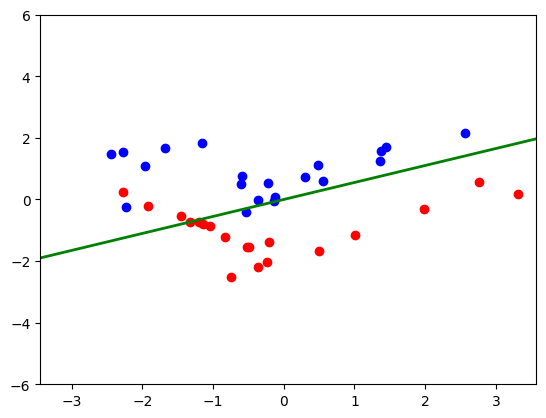

In [22]:
plot_boundary(pos_examples,neg_examples,wts)

## Evaluar en el Conjunto de Prueba

Al principio, apartamos algunos datos para el conjunto de prueba. Veamos qué tan preciso es nuestro clasificador en este conjunto de prueba. Para ello, también expandimos el conjunto de prueba con una dimensión extra, multiplicamos por la matriz de pesos, y verificamos que el valor obtenido tenga el mismo signo que la etiqueta (+1 o -1). Luego sumamos todos los valores booleanos y dividimos por la longitud de la muestra de prueba para obtener la precisión:


In [23]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

np.float64(1.0)

## Limitaciones del Perceptrón

Como has visto arriba, el perceptrón es un **clasificador lineal**. Puede distinguir entre dos clases si son **linealmente separables**, es decir, si pueden separarse por una línea recta. De lo contrario, el proceso de entrenamiento del perceptrón no convergerá.

Un ejemplo obvio de un problema que no puede ser resuelto por un perceptrón es el llamado **problema XOR**. Queremos que nuestro perceptrón aprenda la función booleana XOR, que tiene la siguiente tabla de verdad:

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 | 
| 1 | 1 | 0 |

¡Intentémoslo! Vamos a poblar manualmente todas las muestras positivas y negativas de entrenamiento, y luego llamaremos a nuestra función de entrenamiento definida arriba:



In [28]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

wts = train(pos_examples_xor,neg_examples_xor, num_iterations=100,eta=1)
print(wts.transpose())

Iteration=0, pos correct=0.0, neg correct=1.0
Iteration=10, pos correct=0.0, neg correct=1.0
Iteration=20, pos correct=0.5, neg correct=0.5
Iteration=30, pos correct=0.5, neg correct=0.5
Iteration=40, pos correct=1.0, neg correct=0.5
Iteration=50, pos correct=0.0, neg correct=1.0
Iteration=60, pos correct=0.0, neg correct=1.0
Iteration=70, pos correct=0.5, neg correct=0.5
Iteration=80, pos correct=1.0, neg correct=0.5
Iteration=90, pos correct=0.0, neg correct=1.0
[[-1.  0.  0.]]


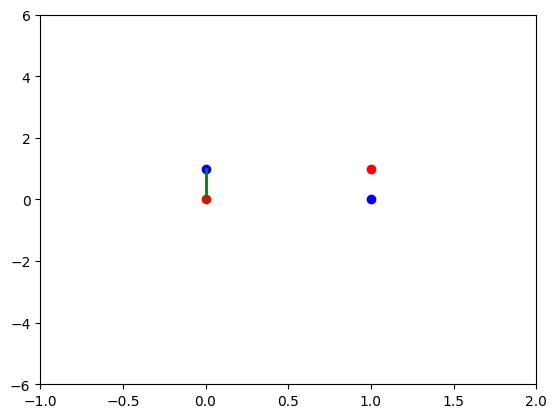

In [29]:
plot_boundary(pos_examples_xor,neg_examples_xor,wts)

## Ejemplo Complejo - MNIST

Aunque el perceptrón no puede resolver el problema XOR, puede resolver muchos problemas más complejos, como el reconocimiento de caracteres escritos a mano.

Un conjunto de datos que se usa a menudo para aprender machine learning se llama [MNIST](https://en.wikipedia.org/wiki/MNIST_database). Fue creado por el Instituto Nacional de Estándares y Tecnología Modificado, y contiene un conjunto de entrenamiento de 60,000 dígitos escritos a mano, recolectados de alrededor de 250 estudiantes y empleados del instituto. También hay un conjunto de prueba de 10,000 dígitos, recolectados de diferentes individuos.

Todos los dígitos están representados por imágenes en escala de grises de tamaño 28x28 píxeles.

> El conjunto de datos MNIST está disponible como una competencia de entrenamiento en [Kaggle](https://www.kaggle.com/c/digit-recognizer), un sitio que alberga competencias y concursos de machine learning. Una vez que aprendas a clasificar los dígitos MNIST, puedes enviar tu solución a Kaggle para ver cómo se compara con otros participantes.

Comenzamos cargando el conjunto de datos MNIST:

Ahora vamos a graficar el conjunto de datos:





Text(0, 0.5, '$x_2$')

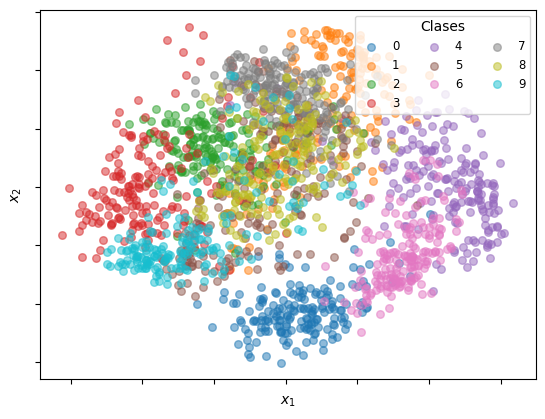

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import math

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA


# load the data
digits = load_digits()


pca = PCA(n_components=2)
data = pca.fit_transform(digits.data)
labels= digits.target

plt.figure()

for i in np.unique(labels):
    plt.scatter(data[labels == i, 0], data[labels == i, 1], label=digits.target_names[i], s=30.0, alpha=0.5)

plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

ax = plt.gca()
ax.legend(loc="upper right", title="Clases", fontsize='small', markerscale=1, ncol=3)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

In [33]:
data.shape, labels.shape

((1797, 2), (1797,))

Grafiquemos el dataset:

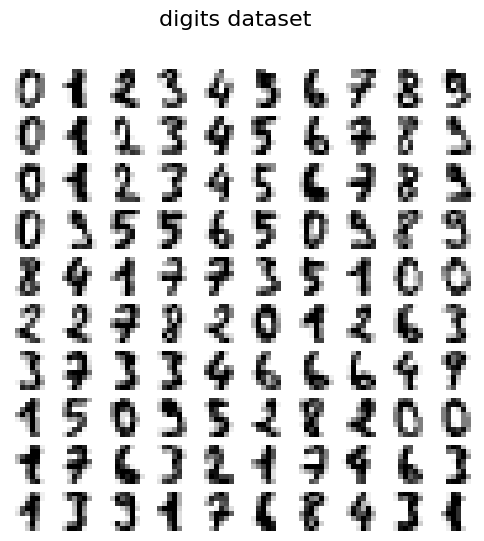

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(digits.data[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("digits dataset", fontsize=16)

In [17]:
data.shape,labels.shape

((1797, 2), (1797,))

Como el perceptrón es un clasificador binario, limitaremos nuestro problema a reconocer solo dos dígitos. La siguiente función poblará los arreglos de muestras positivas y negativas con dos dígitos dados (y también mostrará ejemplos de esos dígitos para mayor claridad).

Comenzaremos intentando clasificar entre 0 y 1:



In [34]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = (labels==positive_label)
    negative_indices = (labels==negative_label)
    positive_images = data[positive_indices]
    negative_images = data[negative_indices]
    positive_images=np.c_[ positive_images, np.ones(positive_images.shape[0]) ]
    negative_images=np.c_[ negative_images, np.ones(negative_images.shape[0]) ]   
    return positive_images, negative_images

We will start by trying to classify between 0 and 1:

In [35]:
pos1,neg1 = set_mnist_pos_neg(0,1)

In [36]:
pos1.shape, neg1.shape

((178, 3), (182, 3))

In [37]:
wts=train(pos1, neg1, num_iterations = 1000)

Iteration=0, pos correct=0.9943820224719101, neg correct=0.8681318681318682
Iteration=100, pos correct=1.0, neg correct=0.9065934065934066
Iteration=200, pos correct=1.0, neg correct=0.9230769230769231
Iteration=300, pos correct=1.0, neg correct=0.9505494505494505
Iteration=400, pos correct=1.0, neg correct=0.9560439560439561
Iteration=500, pos correct=1.0, neg correct=0.9120879120879121
Iteration=600, pos correct=0.9775280898876404, neg correct=0.9945054945054945
Iteration=700, pos correct=1.0, neg correct=0.9175824175824175
Iteration=800, pos correct=1.0, neg correct=0.9560439560439561
Iteration=900, pos correct=0.9943820224719101, neg correct=0.9120879120879121


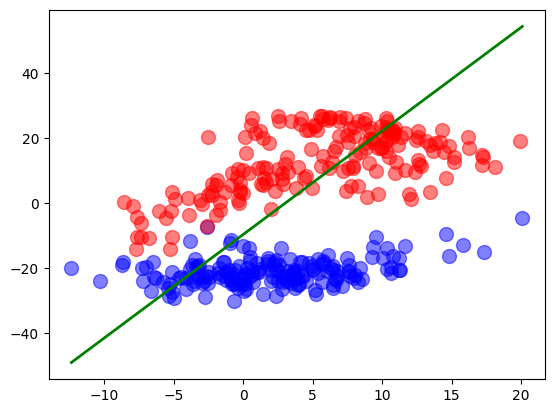

In [38]:
plt.scatter(pos1[:,0], pos1[:,1], marker='o', c='b', s=100, alpha = 0.5, label='0')
plt.scatter(neg1[:,0], neg1[:,1], marker='o', c='r', s=100, alpha = 0.5, label='1')
x=np.linspace(np.min(pos1[:,0]), np.max(pos1[:,0]), 100)
y = -x*wts[1]/wts[0]+wts[2]/wts[0]
plt.plot(x,y,'-g',linewidth=2)
plt.show()

Observa cómo la precisión sube casi al 100% muy rápido.

Por favor, mueve el control deslizante hacia alguna posición al final del entrenamiento y observa la matriz de pesos graficada a la izquierda. Esta matriz te permitirá entender cómo funciona realmente el perceptrón. Puedes ver los valores altos de peso en el centro del campo, que corresponden a los píxeles que normalmente están presentes en el dígito 1, y valores negativos bajos en los lados, donde están partes del dígito 0. Así, si el dígito presentado al perceptrón es de hecho un 1, la parte central se multiplicará por valores altos, produciendo un resultado positivo. Por el contrario, cuando el perceptrón observa un 0, los píxeles correspondientes se multiplicarán por números negativos.

> Puedes notar que si le damos al perceptrón un dígito 1 ligeramente desplazado horizontalmente, de modo que sus píxeles ocupen el lugar donde hay partes verticales del 0, podríamos obtener un resultado incorrecto. Dado que la naturaleza de nuestro conjunto de datos MNIST es tal que todos los dígitos están centrados y posicionados correctamente, el perceptrón depende de esto para distinguir entre los dígitos.

In [58]:
pos2,neg2 = set_mnist_pos_neg(2,5)
train(pos2, neg2, num_iterations = 1000, eta=1e-1)

Iteration=0, pos correct=0.062146892655367235, neg correct=0.5
Iteration=100, pos correct=0.9265536723163842, neg correct=0.37362637362637363
Iteration=200, pos correct=0.0, neg correct=0.9945054945054945
Iteration=300, pos correct=0.8813559322033898, neg correct=0.6483516483516484
Iteration=400, pos correct=0.8361581920903954, neg correct=0.6648351648351648
Iteration=500, pos correct=0.8926553672316384, neg correct=0.5164835164835165
Iteration=600, pos correct=0.8983050847457628, neg correct=0.5054945054945055
Iteration=700, pos correct=0.3163841807909605, neg correct=0.8846153846153846
Iteration=800, pos correct=0.7627118644067796, neg correct=0.6318681318681318
Iteration=900, pos correct=0.7909604519774012, neg correct=0.6758241758241759


array([[-0.49861819],
       [ 1.37563541],
       [-9.        ]])

## Discusion

Ahora probemos con dígitos diferentes:

Por alguna razón, 2 y 5 no son tan fácilmente separables. Aunque obtenemos una precisión relativamente alta (por encima del 85%), podemos ver claramente cómo el perceptrón deja de aprender en cierto punto.

Para entender por qué ocurre esto, podemos intentar usar [Análisis de Componentes Principales](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). Es una técnica de machine learning utilizada para reducir la dimensionalidad del conjunto de datos de entrada, de modo que se obtenga la mejor separabilidad entre clases.

En nuestro caso, una imagen de entrada tiene 784 píxeles (características de entrada), y queremos usar PCA para reducir el número de parámetros a solo 2, para poder graficarlos. Esos dos parámetros serían una combinación lineal de las características originales, y podemos ver este procedimiento como "rotar" nuestro espacio original de 784 dimensiones y observar su proyección en nuestro espacio 2D, hasta obtener la mejor vista que separa las clases.




Como puedes ver, 0 y 1 pueden separarse claramente por una línea recta. Esto indica que en el espacio original de 784 dimensiones los puntos correspondientes a los dígitos también son linealmente separables. En el caso de 2 y 5, no podemos encontrar una buena proyección que separe claramente los dígitos, y por lo tanto hay algunos casos de clasificación incorrecta.


## Tarea

 * Implementar una versión del perceptrón multi-clase.
 * Compare sus resultados con la biblioteca ´sk-learn´



In [80]:
def train_multiclass_ova(data, labels, num_classes, num_iterations=1000,eta=0.1):
    """
    Entrena un perceptrón multi-clase usando la estrategia One-vs-All (OVA).
    Retorna una matriz de pesos, donde cada fila corresponde a los pesos de una clase.
    """
    weights = []
    for class_idx in range(num_classes):
        # Etiquetas para OVA: +1 para la clase actual, -1 para las demás
        pos_examples = data[labels == class_idx]
        neg_examples = data[labels != class_idx]
        # Añadir dimensión de sesgo
        pos_examples = np.c_[pos_examples, np.ones(pos_examples.shape[0])]
        neg_examples = np.c_[neg_examples, np.ones(neg_examples.shape[0])]
        # Entrenar perceptrón binario
        w = train(pos_examples, neg_examples, num_iterations,eta)
        weights.append(w.reshape(-1))
    return np.array(weights)

def predict_multiclass_ova(weights, x):
    """
    Predice la clase para una muestra x usando los pesos entrenados OVA.
    """
    x=np.c_[data,np.ones(data.shape[0])] # Añadir dimensión de sesgo
    scores = np.dot(x,weights.T)
    return np.argmax(scores,axis=1)

In [100]:
num_classes = len(np.unique(labels))
weights=train_multiclass_ova(data, labels, num_classes, num_iterations=1000,eta=1e-1)

Iteration=0, pos correct=0.9325842696629213, neg correct=0.5731933292155652
Iteration=100, pos correct=0.42696629213483145, neg correct=0.5453983940704138
Iteration=200, pos correct=0.9943820224719101, neg correct=0.6399011735639284
Iteration=300, pos correct=0.9213483146067416, neg correct=0.6930203829524397
Iteration=400, pos correct=0.9438202247191011, neg correct=0.7875231624459543
Iteration=500, pos correct=0.9943820224719101, neg correct=0.7059913526868438
Iteration=600, pos correct=0.9943820224719101, neg correct=0.7479925880172946
Iteration=700, pos correct=0.0, neg correct=0.8696726374305127
Iteration=800, pos correct=0.9157303370786517, neg correct=0.9085855466337245
Iteration=900, pos correct=0.9887640449438202, neg correct=0.7547869054972205
Iteration=0, pos correct=0.7252747252747253, neg correct=0.556656346749226
Iteration=100, pos correct=0.8516483516483516, neg correct=0.5839009287925696
Iteration=200, pos correct=0.8461538461538461, neg correct=0.5845201238390093
Itera

In [101]:
y_hat=predict_multiclass_ova(weights, data)

In [102]:
np.sum(labels==y_hat)/len(labels)

np.float64(0.36449638286032277)

In [103]:
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(data, labels)
clf.score(data,labels)

0.39343350027824153

In [105]:
from sklearn.datasets import load_digits
from sklearn.linear_model import Perceptron
X, y = load_digits(return_X_y=True)
clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X, y)
clf.score(X, y)

0.9393433500278241